# MLP
MLP, K=5, droput, 150 epoch.

lncRNA, train + test then valid

In [1]:

from datetime import datetime
print(datetime.now())

2023-04-08 20:02:27.590735


In [2]:
import tensorflow as tf
dt='float32'
tf.keras.backend.set_floatx('float32')
# tf.random.set_seed(42) # supposedly leads to reproducible results

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
    print('GPU device not found')
else:
    print('Found GPU at: {}'.format(device_name))

try:
    from google.colab import drive
    IN_COLAB = True
    print('Running on CoLab')
    PATH='/content/drive/'
    drive.mount(PATH)
    DATA_DIR=PATH+'My Drive/data/Localization/TrainTest/TrainTest_ver43/'  # must end in "/"
    MODEL_DIR=PATH+'My Drive/data/Localization/Models/'  # must end in "/"
except:
    IN_COLAB = False
    DATA_DIR = 'D:/Adjeroh/Localization/TrainTest/'   # Windows
    DATA_DIR = '/Users/jasonmiller/WVU/Localization/TrainTest/TrainTest_ver43/'    # Mac
    MODEL_DIR = '/Users/jasonmiller/WVU/Localization/Models/'    # Mac
print(DATA_DIR)

GPU device not found
Running on CoLab
Mounted at /content/drive/
/content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/


In [3]:
from platform import python_version
print('Python',python_version())
import numpy as np
import pandas as pd
import scipy.stats as ss
import pickle
import time # sleep function
from os.path import isfile
from matplotlib import pyplot as plt 
import sklearn   # pip install --upgrade scikit-learn
print('sklearn',sklearn.__version__)

from tensorflow import keras
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import KFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import auc
from sklearn.metrics import matthews_corrcoef
#from sklearn.utils import class_weight
from sklearn.metrics import confusion_matrix

from keras.models import Sequential
from keras.layers import Masking
from keras.layers import Embedding
from keras.layers import Conv1D
from keras.layers import GlobalAveragePooling1D
from keras.layers import GlobalMaxPooling1D
from keras.layers import AveragePooling1D
from keras.layers import MaxPooling1D
from keras.layers import Bidirectional
from keras.layers import LSTM
from keras.layers import TimeDistributed
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Dropout
from keras.losses import BinaryCrossentropy
#from keras.losses import Hinge

K=5
ALPHABET=4**K + 1
CFILTERS=64 
FILTERSIZE=8
RCELLS=32
DCELLS=16
EPOCHS=150 
EMBED_DIMEN = 4 # arbitrary hyperparameter
# MINLEN=200   # NO LONGER USED
# MAXLEN=5000
PRETTY_PICTURES = True
RCI_THRESHOLD_MECHANISM = 'ZERO'  # 'RCI_GMM' 'ZERO' 'THE_MEAN'
BREAK = False   # break after first fold
EXCLUSIONS = [1]   # possibly exclude cell line 1 = H1.hESC
FILTER_TRAIN        = False
FILTER_TAILS_TRAIN  = False
FILTER_MIDDLE_TRAIN = False
FILTER_TEST         = False
FILTER_TAILS_TEST   = False
FILTER_MIDDLE_TEST  = False
REPEATS = 2
FOLDS = 5

SAVE_MODEL_FILENAME = None # 'MLP_244'

Python 3.9.16
sklearn 1.2.2


In [4]:
RCI_FILE_TRAIN = 'train.lncRNA_RCI.csv'
RCI_FILE_TEST  = None #'test.lncRNA_RCI.csv'

SEQ_FILE_TRAIN = 'train.canon_lncRNA_transcripts.csv'
SEQ_FILE_TEST  = None #'test.canon_lncRNA_transcripts.csv'

In [5]:
def get_ordered_list():
    ordered_list = \
    ['A549','H1.hESC','HeLa.S3','HepG2','HT1080',\
      'HUVEC','MCF.7','NCI.H460','NHEK','SK.MEL.5',\
      'SK.N.DZ','SK.N.SH','GM12878','K562','IMR.90']
    return ordered_list
all_cell_lines = get_ordered_list()

## Data Load

In [6]:
class DataLoader():
    def __init__(self):
        self.cache=dict() 
        self.vals = {'A':0, 'C':1, 'G':2, 'T':3}
        self.gene2rci = dict()
        
    def load_gene_rci_values(self,filepath,exclusions):
        '''
        Load all the genes from the given RCI csv file.
        The given file usually contains train or test, not both.
        Load average RCI for each across cell lines.
        Define average as log of mean of antilogs: log2(mean(2^RCI)).
        Return dict with keys=gene:str and values=RCI:float.
        '''
        self.gene2rci = {}
        overall_sum = 0
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row # skip file's header line
                else:
                    line = row.strip()
                    fields = line.split(',')
                    gene_id = fields.pop(0)
                    cell_line_index = 0
                    rci_values = []
                    log_mean=0.0
                    for rci_str in fields:
                        if cell_line_index not in exclusions:
                            if rci_str != "nan":
                                rci_val = float(rci_str)
                                rci_values.append(rci_val)
                        cell_line_index += 1
                    if len(rci_values)>0:
                        values = np.array(rci_values)
                        antilogs = [2**x for x in values]
                        big_mean = np.mean(antilogs)
                        if np.absolute(big_mean)<0.000001:
                            log_mean = -1000000 # neg infinity
                        else:
                            log_mean = np.log2(big_mean) 
                        self.gene2rci[gene_id] = log_mean
                    # TO DO: get rid of this check on our log/antilog arithmetic.
                    if len(rci_values)==1:
                        diff = rci_values[0]-log_mean
                        if diff>0.000001:
                            print('antilog',log_mean,'not equal',rci_values,'for gene',gene_id)
        print('Number of RCI values loaded',len(self.gene2rci.keys()))
        return self.gene2rci

    def _seq_to_kmer_values(self,rna,K):
        vec=[] # seq converted to list of K-mers 
        N_indicator = 0 # indicator value
        length = len(rna)
        for i in range(length-K+1):
            kmer = rna[i:i+K]
            if 'N' in kmer:
                value = N_indicator
            elif kmer in self.cache.keys():
                value = self.cache[kmer]
            else:
                value = 0
                for j in range(K):
                    value *= 4   
                    nextnuc = kmer[j] 
                    nucval = self.vals[nextnuc]
                    value += nucval
                value += 1   # NNN => 0, AAA => 1
                self.cache[kmer] = value
            vec.append(value)
        return vec

    def load_sequence(self,filepath):
        '''
        Load all the sequences from the given file. 
        Load our version of GenCode -- csv, easier to parse than fasta.
        Each line has IDs plus sequence.
        The IDs in the file do not include dot-version numbers.
        The file may already be filtered e.g. canonical transcripts.
        '''
        allids=[]
        allseq=[]
        #NREPEAT = str('N'*MAXLEN)   # not used for MLP
        with open (filepath,'r') as handle:
            header = None
            for row in handle:
                if header is None:
                    header = row
                else:
                    line    = row.strip()
                    fields  = line.split(',')
                    tran_id = fields[0]  # without version number
                    gene_id = fields[1]  # without version number
                    seq_len = int(fields[3])
                    seq_txt = fields[4]
                    # Keep only transcripts having numeric RCI given the cell lines in use.
                    # We have validated this by spot checking.
                    # TO DO: validate this programmatically.
                    if gene_id in self.gene2rci.keys():
                        # no MAXLEN for MLP
                        #if seq_len<=MAXLEN:
                        #    seq_txt = seq_txt + NREPEAT
                        #seq_txt = seq_txt[:MAXLEN]
                        allids.append( (gene_id,tran_id) )
                        hot_vec = self._seq_to_kmer_values(seq_txt,K)
                        allseq.append(hot_vec)
        self.cache=dict() # save RAM
        return allids,allseq

    def load_spectra(self,filepath):
        '''
        Load all (variable-length) sequences as lists of kmers.
        Then convert each sequence to (fixed-length) kmer histograms.
        '''
        allids,allseq = self.load_sequence(filepath)
        allspectra = []
        for seq in allseq:
            spectrum = np.zeros(ALPHABET)
            for kmer in seq:
                spectrum[kmer] += 1
            spectrum /= len(seq)
            allspectra.append(spectrum)
        return allids,allspectra        


## Model

In [7]:
def build_model():
    mlp    = Sequential()
    layer1 = Dense(128, activation='sigmoid',dtype=dt,input_dim=ALPHABET)
    layer2 = Dense(64, activation='sigmoid')
    drop2  = Dropout(.2)
    layer3 = Dense(64, activation='sigmoid')
    drop3  = Dropout(.2)
    output = Dense(1, activation='sigmoid')
    mlp.add(layer1)
    mlp.add(layer2)
    mlp.add(drop2)
    mlp.add(layer3)
    mlp.add(drop3)
    mlp.add(output)
      
    bc=BinaryCrossentropy(from_logits=False)
    mlp.compile(loss=bc, optimizer="Adam", metrics=["accuracy"])
    return mlp

In [8]:
print(datetime.now())
model=build_model()
print(model.summary())  # Print this only once
model=None

2023-04-08 20:03:04.155926
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 128)               131328    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dropout (Dropout)           (None, 64)                0         
                                                                 
 dense_2 (Dense)             (None, 64)                4160      
                                                                 
 dropout_1 (Dropout)         (None, 64)                0         
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 143,809
Trainab

## Training

In [9]:
import gc
class CrossValidator():
    def __init__(self,epochs,score_threshold=0.5):
        self.epochs = epochs
        self.score_threshold = score_threshold
        self.mechanism = 'ZERO'
        self.discriminator = -1 # or zero
        self.flip = False
        self.reset_statistics()
        
    def reset_statistics(self):
        self.cv_accuracy=[]
        self.cv_precision=[]
        self.cv_recall=[]
        self.cv_f1=[]
        self.cv_auprc=[]
        self.cv_auroc=[]
        self.cv_mcc=[]
        
    def _get_X_y(self, all_ids, all_seqs, rci_map): 
        # Prepare X and y for training or testing.
        subsetX=[]
        subsetY=[]
        for t in range(len(all_ids)):
            gene_id,tran_id = all_ids[t]
            oneX            = all_seqs[t]
            oneY            = rci_map[gene_id]
            subsetX.append(oneX)
            subsetY.append(oneY)
        subsetX = np.array(subsetX)
        subsetY = np.array(subsetY).reshape((-1,1))
        return subsetX,subsetY
    
    def set_threshold_mechanism(self, mechanism):
        if mechanism not in ['RCI_GMM','THE_MEAN','ZERO']:
            raise Exception('Unrecognized mechansm:',mechanism)
        self.mechanism = mechanism
    
    def _apply_threshold(self, array_of_rci):
        # Takes list of float, returns list of labels [0,1].
        if self.mechanism == 'RCI_GMM':
            labels = self.discriminator.predict(array_of_rci)
            if self.flip:
                IS_CYTO = lambda label: 1 if label==0 else 0
                labels = np.array(list(map(IS_CYTO, labels)))
        else:  # 'THE_MEAN' or 'ZERO'
            rci_threshold = self.discriminator
            IS_CYTO = lambda rci: 1 if rci>rci_threshold else 0
            labels = np.array(list(map(IS_CYTO, array_of_rci)))
        return labels
    
    def _prepare_threshold(self, rci_values, create=True):
        if self.mechanism == 'RCI_GMM':
            if create:  # during training, create a new GMM
                gmm = GaussianMixture(n_components=2, verbose=0, 
                  covariance_type='spherical', n_init=100) # random_state=42) 
                gmm.fit(rci_values)
            else:   # during testing, use existing GMM
                gmm=self.discriminator
            self.flip = False
            # The GMM labels are arbitrary.
            if gmm.means_[0][0] > gmm.means_[1][0]:
                self.flip = True
            self.discriminator = gmm   # redundant but consistent
        elif self.mechanism == 'THE_MEAN':
            self.discriminator = np.mean(rci_values)
        elif self.mechanism == 'ZERO':
            self.discriminator = -1   # 0 usually, -1 is as in Yuan et al.
        else: # not expected
            self.discriminator = 0
    
    def _explain_threshold(self):
        if self.mechanism == 'RCI_GMM':
            gmm=self.discriminator
            print('Discriminator is GMM')
            print('Means',[gmm.means_[0][0],gmm.means_[1][0]])
            print('Variances',gmm.covariances_)
            print('Priors',gmm.weights_)
            test_rcis=[-5,-4,-3.5,-3,-2.5,-2,-1.5,-1,-0.5,0,0.5,1,1.5,2,3]
            print(test_rcis)
            print(self._apply_threshold(np.array(test_rcis).reshape((-1,1))))
        else:
            print('Discriminator',self.mechanism,self.discriminator)
    
    def _show_sizes(self,label,values):
        a = np.count_nonzero(values==1)
        b = np.count_nonzero(values==0)
        print('%s 1:0 %d:%d %5.2f%%'%(label,a,b,100*a/(a+b)))
        
    def save_model(self,filename):
        if self.model is not None:
            filepath = MODEL_DIR + filename
            self.model.save(filepath)
            print('Saved model to',filepath)
        
    def load_model(self,filename):
        filepath = MODEL_DIR + filename
        self.model = keras.models.load_model(filepath)
        print('Loaded model from',filepath)
        
    def train_new_model(self,train_ids,train_seq,train_rci,
            valid_ids=None,valid_seq=None,valid_rci=None):
        print(datetime.now())
        X_train,y_rci = self._get_X_y(train_ids,train_seq,train_rci) 
        self._prepare_threshold(y_rci,True)  
        self._explain_threshold()
        y_train = self._apply_threshold(y_rci)
        self._show_sizes('Train',y_train)
        #cw = class_weight.compute_class_weight('balanced', classes=[0,1], y=y_train)
        #cwd = {0: cw[0], 1: cw[1]}
        #print('Computed class weights:',cwd)
        if valid_ids is not None:
            X_valid,y_rci = self._get_X_y(valid_ids,valid_seq,valid_rci) 
            y_valid = self._apply_threshold(y_rci)
            self._show_sizes('Valid',y_valid)
        y_rci = None

        self.model=build_model()
        print("FIT")
        print(datetime.now())
        if valid_ids is None:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            )  # no validation # class_weight=cwd)
        else:
            history=self.model.fit(X_train, y_train, # batch_size=10, default=32 works nicely
            epochs=self.epochs, verbose=0,  # verbose=1 for ascii art, verbose=0 for none 
            validation_data=(X_valid,y_valid) ) # class_weight=cwd, 

        if PRETTY_PICTURES:
            pd.DataFrame(history.history).plot(figsize=(8,5))
            plt.grid(True)
            plt.gca().set_ylim(0,1)
            plt.show()
        
    def test_without_training(self,test_ids,test_seq,test_rci):
        # For final test, do no train.
        # Assume set_sequences() set the test set.
        print(datetime.now())
        X_test,y_rci = self._get_X_y(test_ids,test_seq,test_rci) 
        y_test = self._apply_threshold(y_rci)
        y_rci = None
        
        print("PREDICT")
        print(datetime.now())        
        yhat_pred=self.model.predict(X_test, verbose=0)     
        yhat_classes=np.where(yhat_pred > self.score_threshold, 1, 0)

        self._show_sizes('Test',y_test)
        self._show_sizes('Predict',yhat_classes)
        print('Test sizes',X_test.shape,y_test.shape)
        print('Distrib of scores:',np.mean(yhat_pred),'mean',np.std(yhat_pred),'std')
        print('Range of scores:',np.min(yhat_pred),'to',np.max(yhat_pred))
        print('Score threshold',self.score_threshold)
        cm1 = confusion_matrix(y_test,yhat_classes)
        print('Confusion matrix\n',cm1)
        cm2 = confusion_matrix(y_test,yhat_classes,normalize='all')
        print('Normalized matrix\n',cm2)

        accuracy = accuracy_score(y_test, yhat_classes)*100.
        precision = precision_score(y_test, yhat_classes)*100.
        recall = recall_score(y_test, yhat_classes)*100.
        f1 = f1_score(y_test, yhat_classes)*100.
        prc_Y, prc_X, prc_bins = precision_recall_curve(y_test, yhat_pred)
        auprc = auc(prc_X,prc_Y)*100.
        auroc = roc_auc_score(y_test, yhat_pred)*100.
        mcc = matthews_corrcoef(y_test, yhat_classes)

        correct_pos = 0
        correct_neg = 0
        wrong_pos = 0
        wrong_neg = 0
        for i in range(len(y_test)):
            if yhat_pred[i]>=0.65:
                if y_test[i]==1:
                    correct_pos += 1
                else:
                    wrong_pos += 1
            elif yhat_pred[i]<=0.35:
                if y_test[i]==0:
                    correct_neg += 1
                else:
                    wrong_neg += 1
        print('Extreme scores correct, pos:neg',correct_pos,correct_neg)  
        print('Extreme scores incorrect pos:neg',wrong_pos,wrong_neg)  

        if PRETTY_PICTURES:
            self._pretty_pictures(y_test,yhat_pred,prc_X,prc_Y)
            print('Accuracy: %.2f%% Precision: %.2f%% Recall: %.2f%%' % (accuracy,precision,recall)) 
            print('F1: %.2f%% MCC: %.4f' % (f1,mcc)) 
            print('AUPRC: %.2f%% AUROC: %.2f%%' % (auprc,auroc)) 
        self.cv_accuracy.append(accuracy)
        self.cv_precision.append(precision)
        self.cv_recall.append(recall)
        self.cv_f1.append(f1)
        self.cv_mcc.append(mcc)
        self.cv_auprc.append(auprc)
        self.cv_auroc.append(auroc)

    def _pretty_pictures(self,y_valid,yhat_pred,prc_X,prc_Y):
        count_ones= len(y_valid[y_valid==1])
        count_zeros= len(y_valid[y_valid==0])
        guess = max(count_ones,count_zeros) / len(y_valid)
        # PRC
        plt.plot(prc_X, prc_Y, marker='.')
        plt.plot([0, 1], [guess,guess], linestyle='--')
        plt.xlabel('Recall')
        plt.ylabel('Precision')
        plt.show()
        # ROC
        fpr, tpr, roc_bins = roc_curve(y_valid, yhat_pred)
        plt.plot(fpr, tpr, marker='.')
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.show()
        
    def get_statistics(self):
        return \
        self.cv_accuracy,\
        self.cv_precision,\
        self.cv_recall,\
        self.cv_f1,\
        self.cv_mcc,\
        self.cv_auprc,\
        self.cv_auroc


## Train

In [10]:
class Separator():
    def __init__(self):
        self.train_ids = []
        self.train_seq = []
        self.train_rci = dict()
        self.val_ids = []
        self.val_seq = []
        self.val_rci = dict()
    def load(self,data_dir,rep,fold):
        filename='cv.{}.{}.validation_genes.txt'.format(rep,fold)
        filename = data_dir + filename
        self.val_genes = set()
        print('Opening file',filename)
        with open(filename,'r') as fin:
            for line in fin:
                gene_id = line.strip()
                self.val_genes.add(gene_id)
    def process(self,allids,allseq,gene_to_rci):
        size = len(allids)
        for t in range(size):
            gene_id,tran_id = allids[t]
            oneX            = allseq[t]
            oneY            = gene_to_rci[gene_id]
            in_middle = gene_to_rci[gene_id] >= -2 and gene_to_rci[gene_id] <= 0
            in_tails = gene_to_rci[gene_id] < -2 or gene_to_rci[gene_id] > 0
            if gene_id in self.val_genes:
                if FILTER_TEST and (\
                    (FILTER_TAILS_TEST and in_tails) or \
                    (FILTER_MIDDLE_TEST and in_middle)):
                    pass
                else:
                    self.val_ids.append(allids[t])
                    self.val_seq.append(allseq[t])
                    self.val_rci[gene_id]=gene_to_rci[gene_id]
            else:
                if FILTER_TRAIN and (\
                    (FILTER_TAILS_TRAIN and in_tails) or \
                    (FILTER_MIDDLE_TRAIN and in_middle)):
                    pass
                else:
                    self.train_ids.append(allids[t])
                    self.train_seq.append(allseq[t])
                    self.train_rci[gene_id]=gene_to_rci[gene_id]
    def get_ids(self):
        return self.train_ids,self.val_ids
    def get_seq(self):
        return self.train_seq,self.val_seq
    def get_rci(self):
        return self.train_rci,self.val_rci

2023-04-08 20:03:04.842360
Load RCI from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.lncRNA_RCI.csv
Number of RCI values loaded 5464
Num RCI: 5464
Load sequence from /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/train.canon_lncRNA_transcripts.csv
Loaded 5464 sequences.

Training # 1 1
2023-04-08 20:03:18.947014
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.1.validation_genes.txt
2023-04-08 20:03:19.206852
Discriminator ZERO -1
Train 1:0 2174:2415 47.37%
Valid 1:0 402:473 45.94%
FIT
2023-04-08 20:03:19.301095


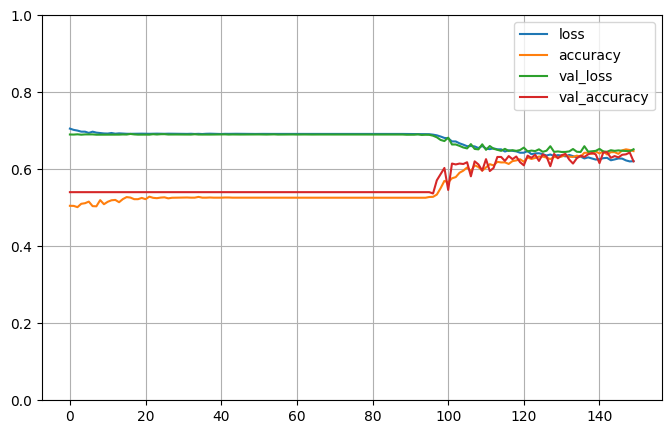


Testing # 1 1
2023-04-08 20:05:42.913082
2023-04-08 20:05:42.913152
PREDICT
2023-04-08 20:05:42.931138
Test 1:0 402:473 45.94%
Predict 1:0 510:365 58.29%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.5104954 mean 0.16647309 std
Range of scores: 0.031010665 to 0.81363547
Score threshold 0.5
Confusion matrix
 [[253 220]
 [112 290]]
Normalized matrix
 [[0.28914286 0.25142857]
 [0.128      0.33142857]]
Extreme scores correct, pos:neg 130 118
Extreme scores incorrect pos:neg 74 40


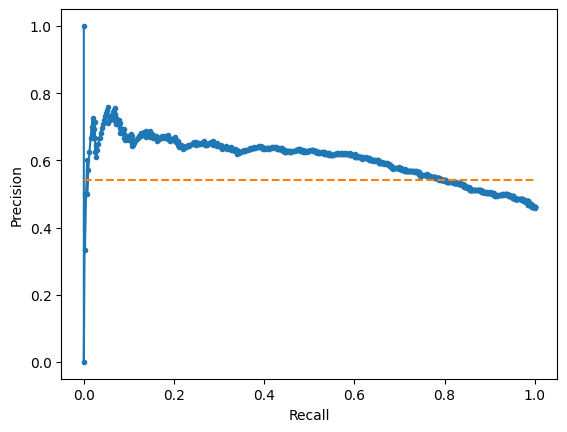

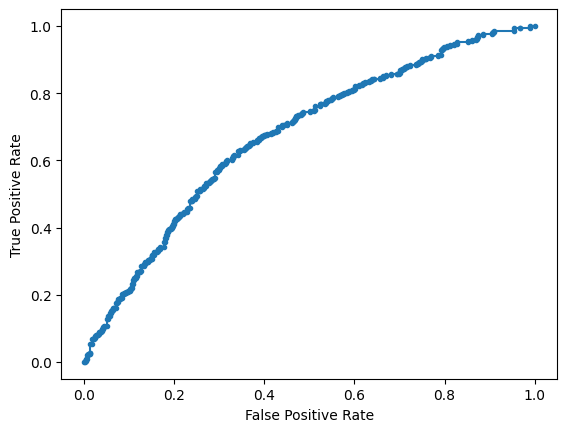

Accuracy: 62.06% Precision: 56.86% Recall: 72.14%
F1: 63.60% MCC: 0.2590
AUPRC: 60.36% AUROC: 67.26%
 accuracy [62.05714285714286]
 precision [56.86274509803921]
 recall [72.13930348258707]
 F1 [63.59649122807017]
 MCC [0.25901284022106263]
 AUPRC [60.36249770496498]
 AUROC [67.2641023213741]

Training # 1 2
2023-04-08 20:05:43.679770
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.2.validation_genes.txt
2023-04-08 20:05:43.936185
Discriminator ZERO -1
Train 1:0 2158:2431 47.03%
Valid 1:0 418:457 47.77%
FIT
2023-04-08 20:05:44.060921


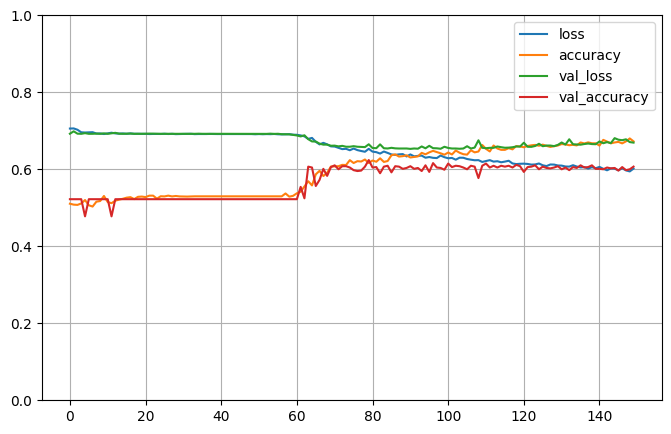


Testing # 1 2
2023-04-08 20:08:07.597639
2023-04-08 20:08:07.598136
PREDICT
2023-04-08 20:08:07.609713
Test 1:0 418:457 47.77%
Predict 1:0 452:423 51.66%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.479694 mean 0.19088376 std
Range of scores: 0.005202125 to 0.8046342
Score threshold 0.5
Confusion matrix
 [[268 189]
 [155 263]]
Normalized matrix
 [[0.30628571 0.216     ]
 [0.17714286 0.30057143]]
Extreme scores correct, pos:neg 112 166
Extreme scores incorrect pos:neg 82 61


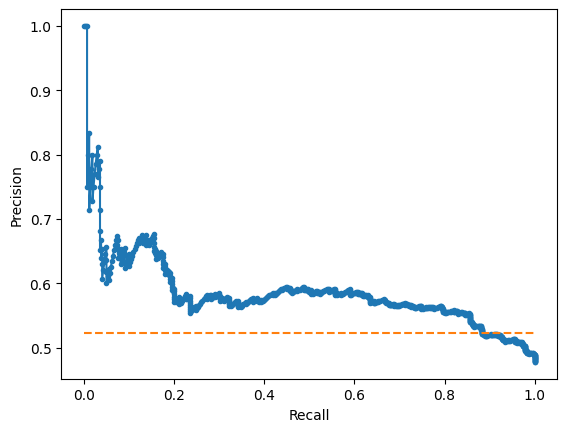

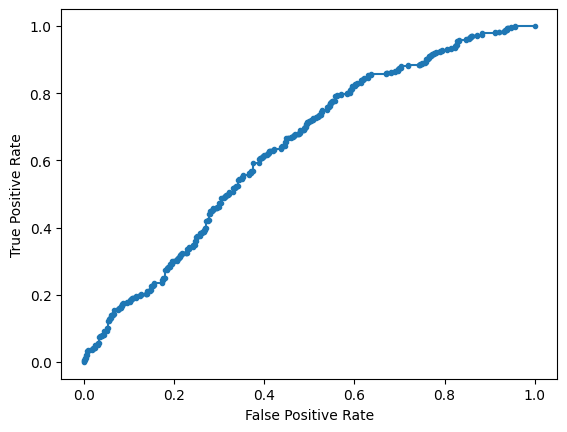

Accuracy: 60.69% Precision: 58.19% Recall: 62.92%
F1: 60.46% MCC: 0.2155
AUPRC: 58.57% AUROC: 63.74%
 accuracy [60.68571428571429]
 precision [58.1858407079646]
 recall [62.91866028708134]
 F1 [60.45977011494252]
 MCC [0.2155239838312276]
 AUPRC [58.57395333034028]
 AUROC [63.73949095934586]

Training # 1 3
2023-04-08 20:08:08.667700
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.3.validation_genes.txt
2023-04-08 20:08:09.135631
Discriminator ZERO -1
Train 1:0 2186:2404 47.63%
Valid 1:0 390:484 44.62%
FIT
2023-04-08 20:08:09.255118


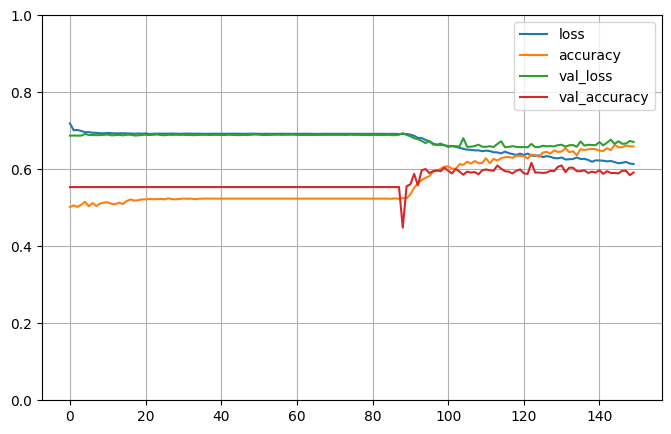


Testing # 1 3
2023-04-08 20:10:33.108827
2023-04-08 20:10:33.111278
PREDICT
2023-04-08 20:10:33.120222
Test 1:0 390:484 44.62%
Predict 1:0 371:503 42.45%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.45797083 mean 0.18369833 std
Range of scores: 0.020300778 to 0.8810296
Score threshold 0.5
Confusion matrix
 [[315 169]
 [188 202]]
Normalized matrix
 [[0.3604119  0.19336384]
 [0.21510297 0.23112128]]
Extreme scores correct, pos:neg 90 189
Extreme scores incorrect pos:neg 62 63


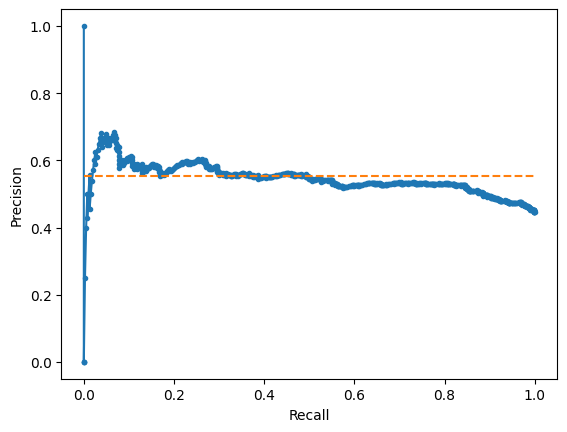

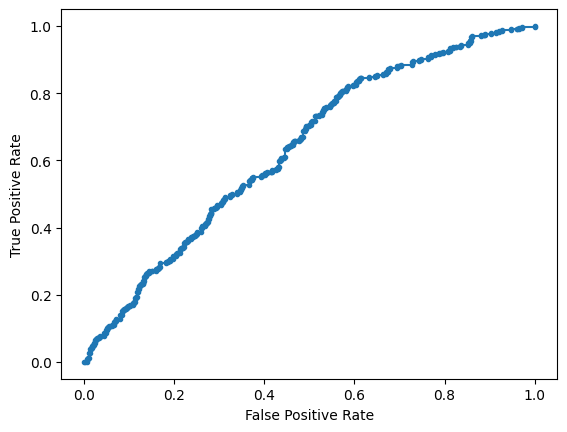

Accuracy: 59.15% Precision: 54.45% Recall: 51.79%
F1: 53.09% MCC: 0.1697
AUPRC: 54.52% AUROC: 63.43%
 accuracy [59.153318077803206]
 precision [54.44743935309974]
 recall [51.7948717948718]
 F1 [53.0880420499343]
 MCC [0.16974327465930664]
 AUPRC [54.521469828012236]
 AUROC [63.43452002542911]

Training # 1 4
2023-04-08 20:10:33.719490
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.4.validation_genes.txt
2023-04-08 20:10:34.171087
Discriminator ZERO -1
Train 1:0 2152:2438 46.88%
Valid 1:0 424:450 48.51%
FIT
2023-04-08 20:10:34.279501


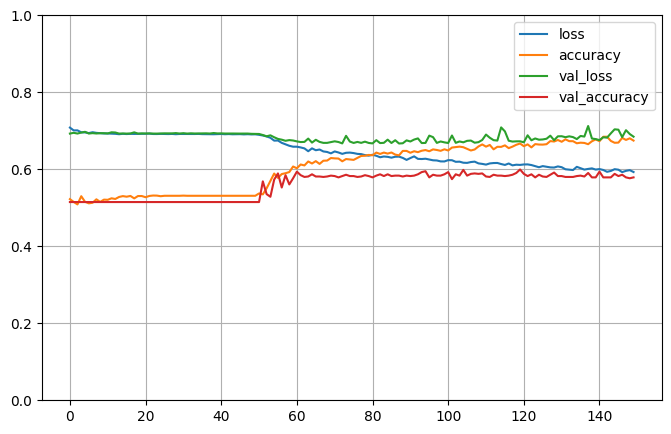


Testing # 1 4
2023-04-08 20:12:57.693843
2023-04-08 20:12:57.694300
PREDICT
2023-04-08 20:12:57.710444
Test 1:0 424:450 48.51%
Predict 1:0 440:434 50.34%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.47931105 mean 0.19643518 std
Range of scores: 0.0029124857 to 0.8050227
Score threshold 0.5
Confusion matrix
 [[258 192]
 [176 248]]
Normalized matrix
 [[0.29519451 0.21967963]
 [0.201373   0.28375286]]
Extreme scores correct, pos:neg 128 161
Extreme scores incorrect pos:neg 72 70


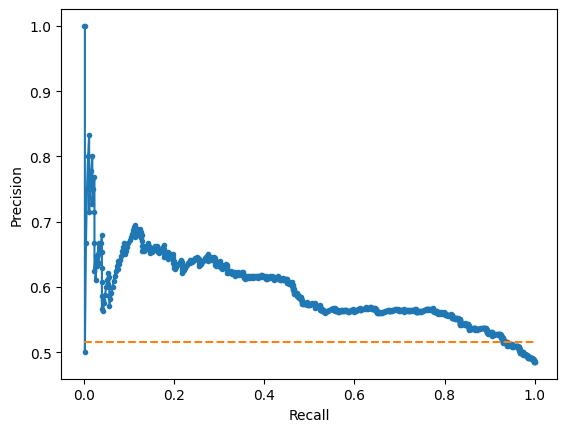

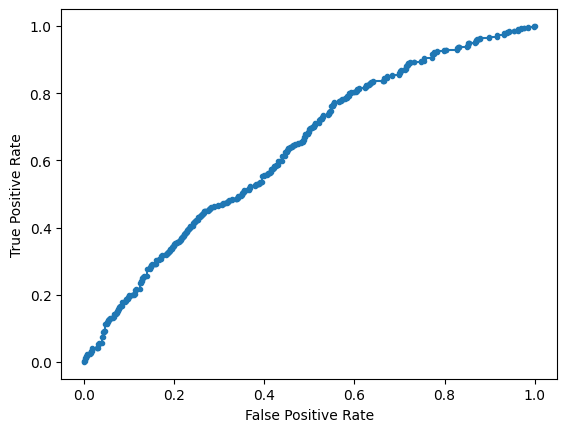

Accuracy: 57.89% Precision: 56.36% Recall: 58.49%
F1: 57.41% MCC: 0.1582
AUPRC: 59.30% AUROC: 63.26%
 accuracy [57.89473684210527]
 precision [56.36363636363636]
 recall [58.490566037735846]
 F1 [57.407407407407405]
 MCC [0.15817268782313343]
 AUPRC [59.30003731779545]
 AUROC [63.26205450733753]

Training # 1 5
2023-04-08 20:12:58.686970
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.1.5.validation_genes.txt
2023-04-08 20:12:59.105974
Discriminator ZERO -1
Train 1:0 2149:2442 46.81%
Valid 1:0 427:446 48.91%
FIT
2023-04-08 20:12:59.258833


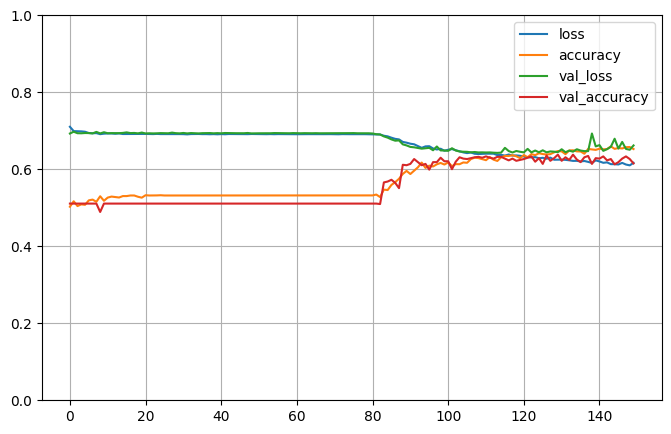


Testing # 1 5
2023-04-08 20:15:08.314591
2023-04-08 20:15:08.315043
PREDICT
2023-04-08 20:15:08.326497
Test 1:0 427:446 48.91%
Predict 1:0 609:264 69.76%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.56458414 mean 0.15285371 std
Range of scores: 0.029344132 to 0.8227553
Score threshold 0.5
Confusion matrix
 [[187 259]
 [ 77 350]]
Normalized matrix
 [[0.21420389 0.29667812]
 [0.0882016  0.40091638]]
Extreme scores correct, pos:neg 198 63
Extreme scores incorrect pos:neg 97 22


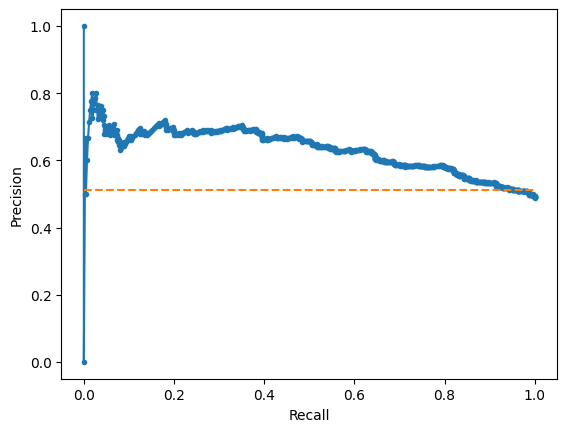

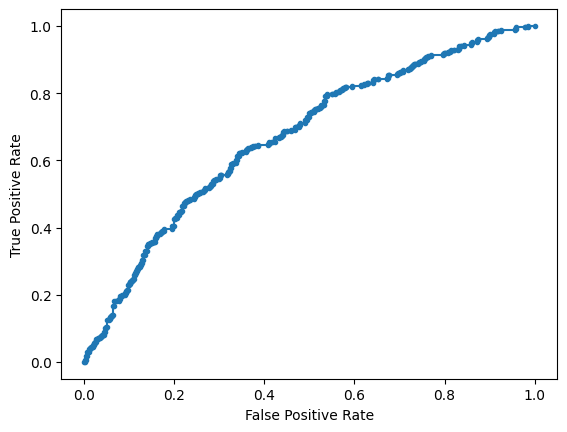

Accuracy: 61.51% Precision: 57.47% Recall: 81.97%
F1: 67.57% MCC: 0.2601
AUPRC: 63.08% AUROC: 66.95%
 accuracy [61.512027491408936]
 precision [57.47126436781609]
 recall [81.9672131147541]
 F1 [67.56756756756756]
 MCC [0.2600675877685225]
 AUPRC [63.08069420628393]
 AUROC [66.94584177859926]

Training # 2 1
2023-04-08 20:15:09.174760
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.1.validation_genes.txt
2023-04-08 20:15:09.638228
Discriminator ZERO -1
Train 1:0 2170:2419 47.29%
Valid 1:0 406:469 46.40%
FIT
2023-04-08 20:15:09.756728


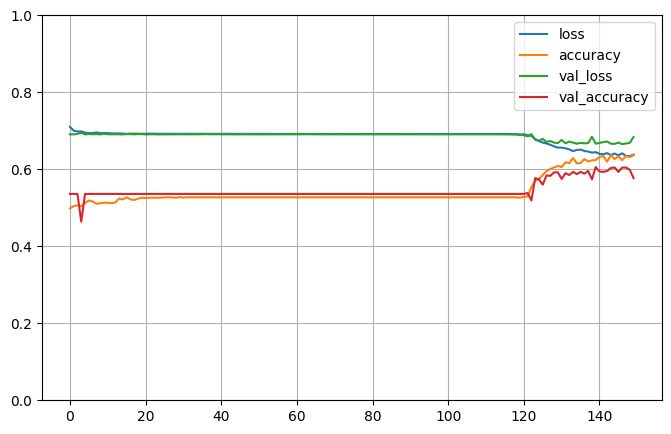


Testing # 2 1
2023-04-08 20:17:33.138828
2023-04-08 20:17:33.138884
PREDICT
2023-04-08 20:17:33.150488
Test 1:0 406:469 46.40%
Predict 1:0 214:661 24.46%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.38718054 mean 0.15627526 std
Range of scores: 0.021021085 to 0.75993836
Score threshold 0.5
Confusion matrix
 [[380  89]
 [281 125]]
Normalized matrix
 [[0.43428571 0.10171429]
 [0.32114286 0.14285714]]
Extreme scores correct, pos:neg 28 238
Extreme scores incorrect pos:neg 17 129


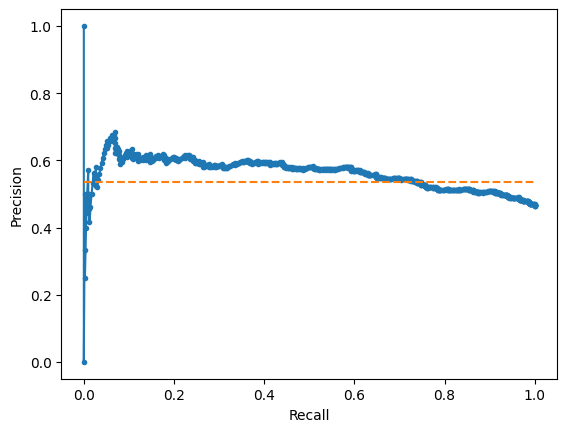

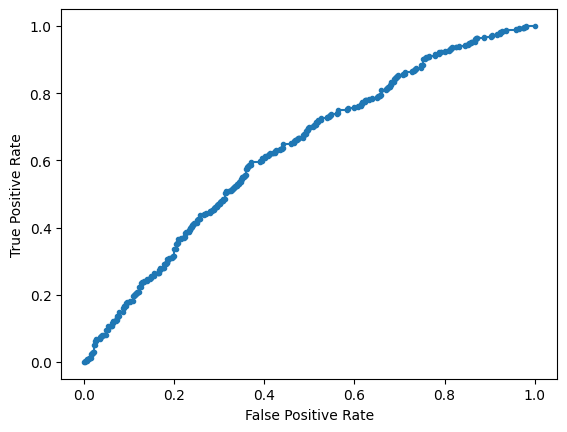

Accuracy: 57.71% Precision: 58.41% Recall: 30.79%
F1: 40.32% MCC: 0.1370
AUPRC: 56.13% AUROC: 63.02%
 accuracy [57.714285714285715]
 precision [58.41121495327103]
 recall [30.78817733990148]
 F1 [40.32258064516129]
 MCC [0.13704137611828004]
 AUPRC [56.13292905163478]
 AUROC [63.01900070372975]

Training # 2 2
2023-04-08 20:17:33.747870
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.2.validation_genes.txt
2023-04-08 20:17:34.529804
Discriminator ZERO -1
Train 1:0 2160:2429 47.07%
Valid 1:0 416:459 47.54%
FIT
2023-04-08 20:17:34.658342


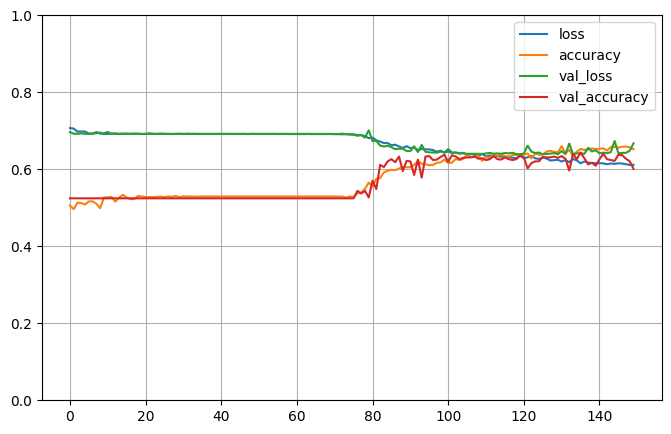


Testing # 2 2
2023-04-08 20:19:58.116030
2023-04-08 20:19:58.116474
PREDICT
2023-04-08 20:19:58.131041
Test 1:0 416:459 47.54%
Predict 1:0 659:216 75.31%
Test sizes (875, 1025) (875,)
Distrib of scores: 0.58269924 mean 0.1463425 std
Range of scores: 0.04055395 to 0.80965006
Score threshold 0.5
Confusion matrix
 [[163 296]
 [ 53 363]]
Normalized matrix
 [[0.18628571 0.33828571]
 [0.06057143 0.41485714]]
Extreme scores correct, pos:neg 218 56
Extreme scores incorrect pos:neg 120 12


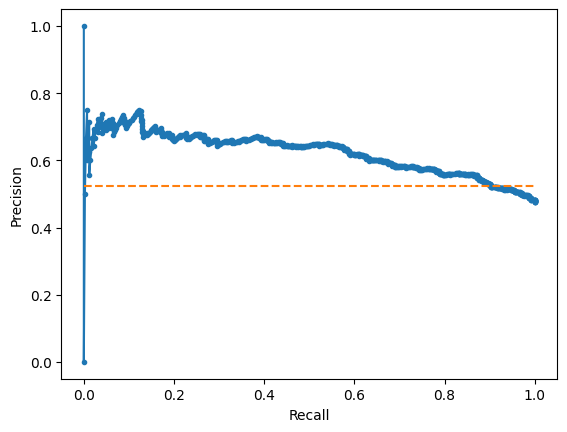

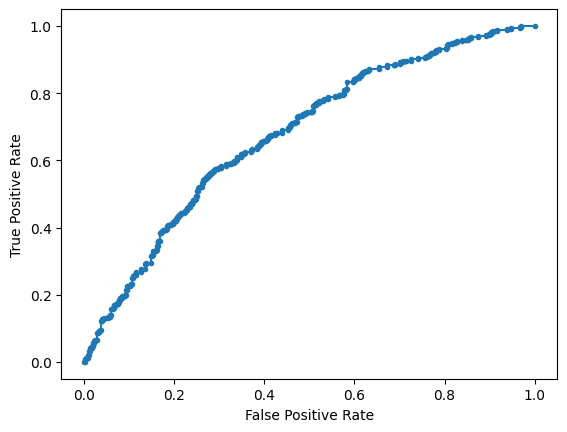

Accuracy: 60.11% Precision: 55.08% Recall: 87.26%
F1: 67.53% MCC: 0.2637
AUPRC: 62.28% AUROC: 67.81%
 accuracy [60.11428571428571]
 precision [55.08345978755691]
 recall [87.25961538461539]
 F1 [67.53488372093024]
 MCC [0.2637405653006717]
 AUPRC [62.28057538805483]
 AUROC [67.80626780626781]

Training # 2 3
2023-04-08 20:19:59.078856
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.3.validation_genes.txt
2023-04-08 20:19:59.359973
Discriminator ZERO -1
Train 1:0 2149:2441 46.82%
Valid 1:0 427:447 48.86%
FIT
2023-04-08 20:19:59.520640


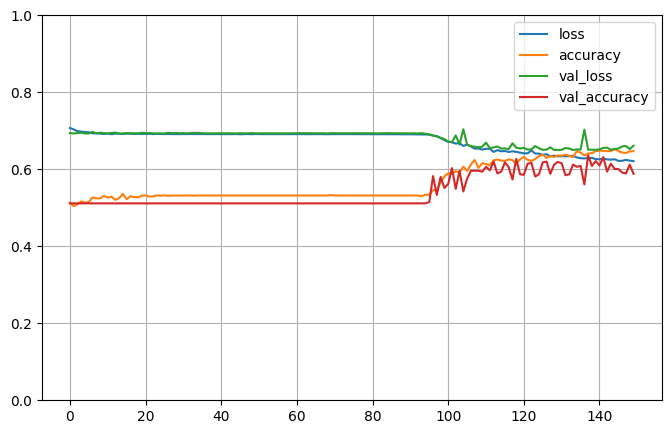


Testing # 2 3
2023-04-08 20:21:57.119307
2023-04-08 20:21:57.119370
PREDICT
2023-04-08 20:21:57.130951
Test 1:0 427:447 48.86%
Predict 1:0 339:535 38.79%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.43854913 mean 0.17539196 std
Range of scores: 0.02804894 to 0.77461416
Score threshold 0.5
Confusion matrix
 [[311 136]
 [224 203]]
Normalized matrix
 [[0.35583524 0.15560641]
 [0.25629291 0.23226545]]
Extreme scores correct, pos:neg 68 201
Extreme scores incorrect pos:neg 39 83


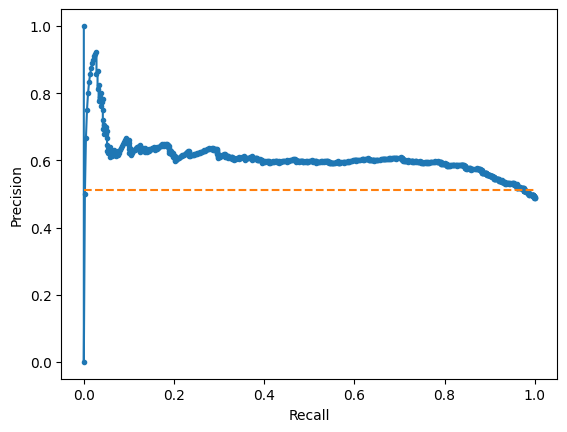

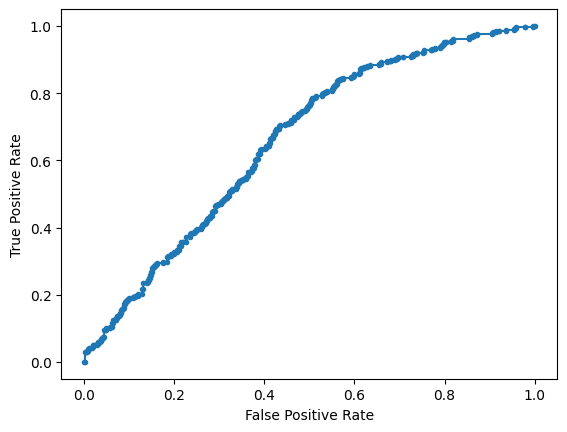

Accuracy: 58.81% Precision: 59.88% Recall: 47.54%
F1: 53.00% MCC: 0.1756
AUPRC: 60.62% AUROC: 65.74%
 accuracy [58.81006864988558]
 precision [59.882005899705014]
 recall [47.540983606557376]
 F1 [53.00261096605744]
 MCC [0.17558661306955267]
 AUPRC [60.62133427019]
 AUROC [65.73513771225291]

Training # 2 4
2023-04-08 20:21:58.338510
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.4.validation_genes.txt
2023-04-08 20:21:58.601737
Discriminator ZERO -1
Train 1:0 2184:2407 47.57%
Valid 1:0 392:481 44.90%
FIT
2023-04-08 20:21:58.699369


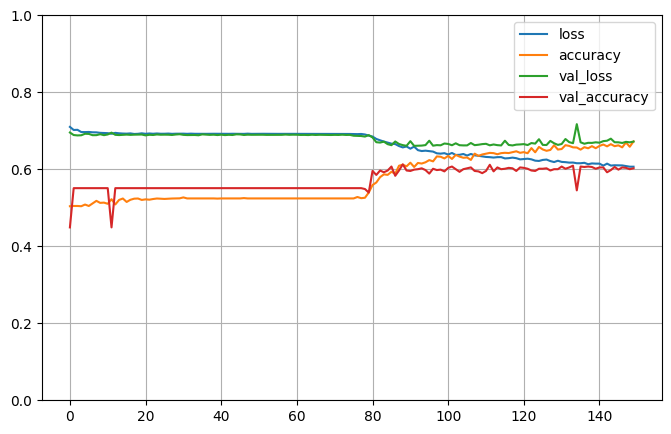


Testing # 2 4
2023-04-08 20:24:21.958716
2023-04-08 20:24:21.958764
PREDICT
2023-04-08 20:24:21.966863
Test 1:0 392:481 44.90%
Predict 1:0 479:394 54.87%
Test sizes (873, 1025) (873,)
Distrib of scores: 0.49833614 mean 0.18081638 std
Range of scores: 0.03280934 to 0.82411957
Score threshold 0.5
Confusion matrix
 [[264 217]
 [130 262]]
Normalized matrix
 [[0.3024055  0.24856816]
 [0.1489118  0.30011455]]
Extreme scores correct, pos:neg 123 138
Extreme scores incorrect pos:neg 86 51


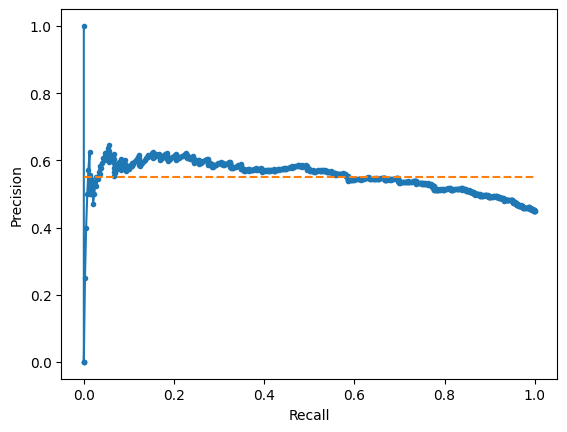

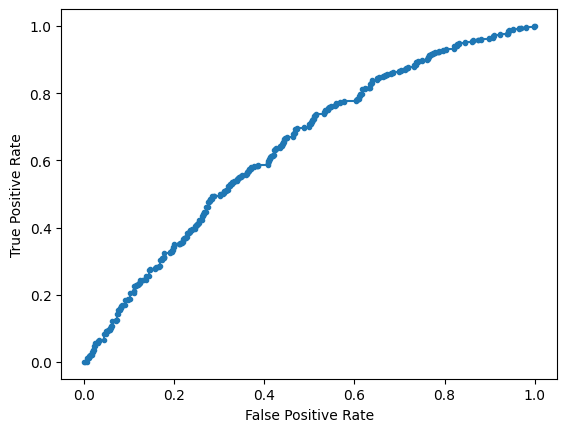

Accuracy: 60.25% Precision: 54.70% Recall: 66.84%
F1: 60.16% MCC: 0.2171
AUPRC: 55.32% AUROC: 64.02%
 accuracy [60.25200458190149]
 precision [54.69728601252609]
 recall [66.83673469387756]
 F1 [60.160734787600454]
 MCC [0.2171237355794119]
 AUPRC [55.32039446961778]
 AUROC [64.02000509143366]

Training # 2 5
2023-04-08 20:24:22.584891
Opening file /content/drive/My Drive/data/Localization/TrainTest/TrainTest_ver43/cv.2.5.validation_genes.txt
2023-04-08 20:24:23.387871
Discriminator ZERO -1
Train 1:0 2156:2434 46.97%
Valid 1:0 420:454 48.05%
FIT
2023-04-08 20:24:23.502183


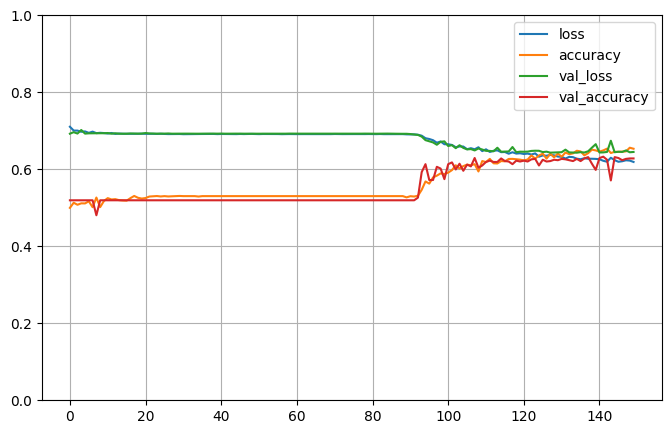


Testing # 2 5
2023-04-08 20:26:47.221124
2023-04-08 20:26:47.221180
PREDICT
2023-04-08 20:26:47.234954
Test 1:0 420:454 48.05%
Predict 1:0 447:427 51.14%
Test sizes (874, 1025) (874,)
Distrib of scores: 0.4896287 mean 0.1683502 std
Range of scores: 0.020190272 to 0.802766
Score threshold 0.5
Confusion matrix
 [[278 176]
 [149 271]]
Normalized matrix
 [[0.3180778  0.201373  ]
 [0.17048055 0.31006865]]
Extreme scores correct, pos:neg 114 138
Extreme scores incorrect pos:neg 54 46


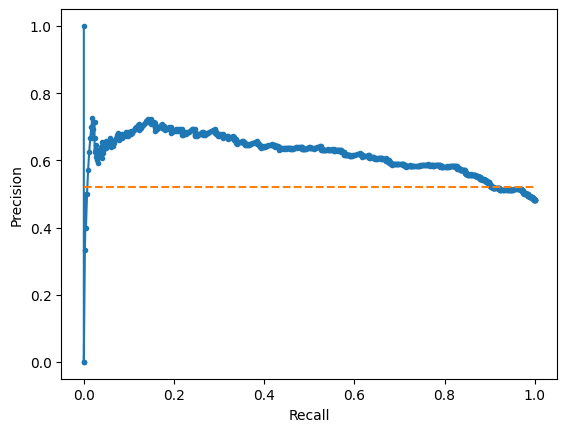

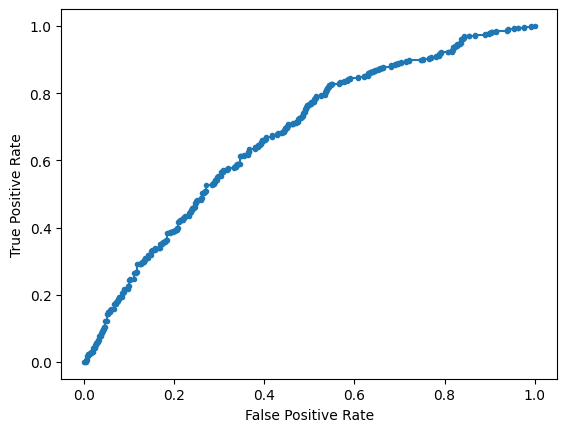

Accuracy: 62.81% Precision: 60.63% Recall: 64.52%
F1: 62.51% MCC: 0.2574
AUPRC: 61.99% AUROC: 67.54%
 accuracy [62.81464530892449]
 precision [60.62639821029083]
 recall [64.52380952380953]
 F1 [62.51441753171857]
 MCC [0.2574453400510713]
 AUPRC [61.98856304913014]
 AUROC [67.53933291378226]
2023-04-08 20:26:47.869203


In [11]:
print(datetime.now())

accuracy=[]
precision=[]
recall=[]
f1=[]
mcc=[]
auprc=[]
auroc=[]

loader = DataLoader()
filepath = DATA_DIR+RCI_FILE_TRAIN
print("Load RCI from",filepath)
gene_to_rci = loader.load_gene_rci_values(filepath,EXCLUSIONS)
print('Num RCI:', len(gene_to_rci.keys()))
filepath = DATA_DIR+SEQ_FILE_TRAIN
print('Load sequence from',filepath)
allids,allseq = loader.load_spectra(filepath)  # for MLP (load_sequence() for CNN)
print('Loaded',len(allseq),'sequences.')
test_gene_to_rci = None
test_allids = None
test_allseq = None
if SEQ_FILE_TEST is not None:
    # Train on the entire train set (no cross-validation).
    # Evaluate with the test files.
    test_loader = DataLoader()
    filepath = DATA_DIR+RCI_FILE_TEST
    print("Load RCI from",filepath)
    test_gene_to_rci = test_loader.load_gene_rci_values(filepath,EXCLUSIONS)
    print('Num RCI:', len(test_gene_to_rci.keys()))
    filepath = DATA_DIR+SEQ_FILE_TEST
    print('Load sequence from',filepath)
    test_allids,test_allseq = test_loader.load_spectra(filepath)
    print('Loaded',len(test_allseq),'sequences.')

for repeat in range(REPEATS):
    for fold in range(FOLDS):
        show_r = repeat+1  # display one-based counting
        show_f = fold+1    # display one-based counting

        print()
        print("Training #",show_r,show_f)
        print(datetime.now())
        cvdo = CrossValidator(EPOCHS)
        cvdo.set_threshold_mechanism(RCI_THRESHOLD_MECHANISM)
        if SEQ_FILE_TEST is None:
            # Train on 80% and evaluate on 20%.
            separator = Separator()
            separator.load(DATA_DIR,show_r,show_f)
            separator.process(allids,allseq,gene_to_rci)
            train_allids,test_allids = separator.get_ids()
            train_allseq,test_allseq = separator.get_seq()
            train_gene_to_rci,test_gene_to_rci = separator.get_rci()
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                test_allids,test_allseq,test_gene_to_rci)
            if SAVE_MODEL_FILENAME is not None:
                filename = f"{SAVE_MODEL_FILENAME}.{show_r}.{show_f}.model"
                cvdo.save_model(filename)
        else:
            # Train on the entire train set (no cross-validation).
            # Evaluate with the test files.
            train_allids = allids
            train_allseq = allseq
            train_gene_to_rci = gene_to_rci
            BREAK = True
            cvdo.train_new_model(
                train_allids,train_allseq,train_gene_to_rci,
                None,None,None)

        print()
        print("Testing #",show_r,show_f)
        print(datetime.now())
        cvdo.reset_statistics()
        cvdo.test_without_training(
            test_allids,test_allseq,test_gene_to_rci)
        cv_accuracy,cv_precision,cv_recall,cv_f1,cv_mcc,cv_auprc,cv_auroc=\
            cvdo.get_statistics()

        print(" accuracy" ,  cv_accuracy)
        print(" precision" , cv_precision)
        print(" recall" ,    cv_recall)
        print(" F1" ,        cv_f1)
        print(" MCC" ,       cv_mcc)
        print(" AUPRC" ,     cv_auprc)
        print(" AUROC" ,     cv_auroc)

        accuracy.append(cv_accuracy)
        precision.append(cv_precision)
        recall.append(cv_recall)
        f1.append(cv_f1)
        mcc.append(cv_mcc)
        auprc.append(cv_auprc)
        auroc.append(cv_auroc)
        if BREAK: break
    if BREAK: break
print(datetime.now())

In [12]:
def STD (values):
    # ddof=1 reduces bias when extrapolating from sample to population
    return np.std(values,ddof=1)

print(" accuracy mean %.2f%% std %.2f" %  (np.mean(accuracy),  STD(accuracy)))
print(" precision mean %.2f%% std %.2f" % (np.mean(precision), STD(precision)))
print(" recall mean %.2f%% std %.2f" %    (np.mean(recall),    STD(recall)))
print(" F1 mean %.2f%% std %.2f" %        (np.mean(f1),        STD(f1)))
print(" MCC mean %.4f std %.4f" %       (np.mean(mcc),       STD(mcc)))
print(" AUPRC mean %.2f%% std %.2f" %     (np.mean(auprc),     STD(auprc)))
print(" AUROC mean %.2f%% std %.2f" %     (np.mean(auroc),     STD(auroc)))

print(" accuracy"  , accuracy)
print(" precision" , precision)
print(" recall"    , recall)
print(" F1"        , f1)
print(" MCC"       , mcc)
print(" AUPRC"     , auprc)
print(" AUROC"     , auroc)



 accuracy mean 60.10% std 1.72
 precision mean 57.20% std 2.12
 recall mean 62.43% std 16.56
 F1 mean 58.57% std 8.19
 MCC mean 0.2113 std 0.0482
 AUPRC mean 59.22% std 3.03
 AUROC mean 65.28% std 1.97
 accuracy [[62.05714285714286], [60.68571428571429], [59.153318077803206], [57.89473684210527], [61.512027491408936], [57.714285714285715], [60.11428571428571], [58.81006864988558], [60.25200458190149], [62.81464530892449]]
 precision [[56.86274509803921], [58.1858407079646], [54.44743935309974], [56.36363636363636], [57.47126436781609], [58.41121495327103], [55.08345978755691], [59.882005899705014], [54.69728601252609], [60.62639821029083]]
 recall [[72.13930348258707], [62.91866028708134], [51.7948717948718], [58.490566037735846], [81.9672131147541], [30.78817733990148], [87.25961538461539], [47.540983606557376], [66.83673469387756], [64.52380952380953]]
 F1 [[63.59649122807017], [60.45977011494252], [53.0880420499343], [57.407407407407405], [67.56756756756756], [40.32258064516129], [6